# Enzyme Project
## Cascade Plot

In [26]:
install.packages("broom")


The downloaded binary packages are in
	/var/folders/fr/ck40byl92gj0l7xb6rxl6hjw0000gp/T//RtmpRH9Xf9/downloaded_packages


In [28]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(scales)

In [29]:
fig6a <- read.csv("../data/fig6a.csv")

In [30]:
sum(fig6a$b1)

[1] 48.04838

In [31]:
normal.vector <- colSums(fig6a)/100

Normalizing all data to a sum equal to sum of buffer normalized fliuorescence intensities

In [32]:
normal.vector[1] = 1

In [33]:
normal.vector

Distance        b1        b2        t1        t2 
1.0000000 0.4804838 0.4788095 0.5040187 0.5354966

In [34]:
fig6a <- mapply("/",fig6a,normal.vector)

In [35]:
colSums(fig6a)

Distance       b1       b2       t1       t2 
27770.62   100.00   100.00   100.00   100.00

In [36]:
fig6a <- as.data.frame(fig6a)

In [37]:
# Putting data in tidy format
fig2m <- gather(fig6a,"Experiment","Concentration",b1:t2)
head(fig2m)

Distance,Experiment,Concentration
0.0000,b1,0
1.8884,b1,0
3.7768,b1,0
5.6652,b1,0
7.5535,b1,0
9.4419,b1,0


Next we specify the model. The solution for our initial conditions is $a * erf(\frac{x-c}{\sqrt{4Dt}}) +b$, where $c$ is the step point at $t=0$, and $a$ and $b$ are determined by inital concentrations. As the geometry is also subject to noise, we add two offset parameters for the inital concentration profile (the locations of the channel limits).

We then fit the model using the `nls` R package. We also use the confidence intervals given by the package to fit the upper and lower bounds of the model.

In [38]:
erf <- function(x) 2*pnorm(x*sqrt(2)) -1
# fig2mgroup <- fig2m %>% group_by(variable)
# models <- list()
m <- function(df) {
    mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = df)
    pred <- fitted(mod)
    data.frame(df,pred)
    params = confint(mod, level= 0.95)
    cc <- coef(mod)
    l <- params[,1]
    u <- params[,2]
    lwr <- l[1]*(erf((df$Distance+l[2]-100)/sqrt(4*l[3])) - erf((df$Distance+u[4]-220)/sqrt(4*l[5])))
    upr <- u[1]*(erf((df$Distance+u[2]-100)/sqrt(4*u[3])) - erf((df$Distance+l[4]-220)/sqrt(4*u[5])))
    data.frame(df,pred,lwr,upr,cc[2],cc[4])
}
result <- fig2m %>% group_by(Experiment) %>% do(m(.))
models <- fig2m %>% group_by(Experiment) %>% do(model = nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = .))
library(plyr)
result <- rename(result,c("cc.2."="offsetleft","cc.4."="offsetright"))
glimpse(result)


Warning message in nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * :
“No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart model”Waiting for profiling to be done...
Warning message in data.frame(df, pred, lwr, upr, cc[2], cc[4]):
“row names were found from a short variable and have been discarded”Warning message in nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * :
“No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart model”Waiting for profiling to be done...
Warning message in data.frame(df, pred, lwr, upr, cc[2], cc[4]):
“row names were found from a short variable and have been discarded”Warning message in nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * :
“No starting values specified for some parameters.
In

Observations: 688
Variables: 8
$ Distance      <dbl> 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    <chr> "b1", "b1", "b1", "b1", "b1", "b1", "b1", "b1", "b1",...
$ Concentration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          <dbl> 2.986087e-09, 5.238870e-09, 9.114322e-09, 1.572409e-0...
$ lwr           <dbl> 1.569790e-09, 2.804232e-09, 4.966186e-09, 8.719092e-0...
$ upr           <dbl> 5.561151e-09, 9.587549e-09, 1.639510e-08, 2.780907e-0...
$ offsetleft    <dbl> -20.86433, -20.86433, -20.86433, -20.86433, -20.86433...
$ offsetright   <dbl> 9.411884, 9.411884, 9.411884, 9.411884, 9.411884, 9.4...


In [39]:
#adding channel data
result$channel <- 0
result$channel[result$Distance <= 100] <- 'left'
result$channel[result$Distance > 100 & result$Distance <= 220] <- 'center'
result$channel[result$Distance > 220] <- 'right'
glimpse(result)

Observations: 688
Variables: 9
$ Distance      <dbl> 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    <chr> "b1", "b1", "b1", "b1", "b1", "b1", "b1", "b1", "b1",...
$ Concentration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          <dbl> 2.986087e-09, 5.238870e-09, 9.114322e-09, 1.572409e-0...
$ lwr           <dbl> 1.569790e-09, 2.804232e-09, 4.966186e-09, 8.719092e-0...
$ upr           <dbl> 5.561151e-09, 9.587549e-09, 1.639510e-08, 2.780907e-0...
$ offsetleft    <dbl> -20.86433, -20.86433, -20.86433, -20.86433, -20.86433...
$ offsetright   <dbl> 9.411884, 9.411884, 9.411884, 9.411884, 9.411884, 9.4...
$ channel       <chr> "left", "left", "left", "left", "left", "left", "left...


In [40]:
detach("package:plyr", unload=TRUE)

Warning message:
“‘plyr’ namespace cannot be unloaded:
  namespace ‘plyr’ is imported by ‘scales’, ‘ggplot2’, ‘reshape2’, ‘broom’ so cannot be unloaded”

In [41]:
groupy <- group_by(result,channel,Experiment)
summed <- summarise(groupy, pred = sum(pred), lwr = sum(lwr), upr = sum(upr), actual = sum(Concentration))
names(summed)[2] = 'experiment'
summed <- gather(summed, "variable","value", c(pred,actual))
summed$upr[summed$variable == 'actual'] <- NaN
summed$lwr[summed$variable == 'actual'] <- NaN

In [42]:
head(result)

Distance,Experiment,Concentration,pred,lwr,upr,offsetleft,offsetright,channel
0.0000,b1,0,2.986087e-09,1.569790e-09,5.561151e-09,-20.86433,9.411884,left
1.8884,b1,0,5.238870e-09,2.804232e-09,9.587549e-09,-20.86433,9.411884,left
3.7768,b1,0,9.114322e-09,4.966186e-09,1.639510e-08,-20.86433,9.411884,left
5.6652,b1,0,1.572409e-08,8.719092e-09,2.780907e-08,-20.86433,9.411884,left
7.5535,b1,0,2.689994e-08,1.517570e-08,4.678601e-08,-20.86433,9.411884,left
9.4419,b1,0,4.563619e-08,2.618689e-08,7.807810e-08,-20.86433,9.411884,left


In [43]:
result %<>% group_by(Experiment) %>% mutate(Experiment.Type = substring(Experiment,1,1) )

In [44]:
control.conc = filter(result, Experiment.Type == 'b')$Concentration
control.pred = filter(result, Experiment.Type == 'b')$pred
result %<>% group_by(Experiment.Type)%>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()


In [45]:
summed

channel,experiment,lwr,upr,variable,value
center,b1,93.427840,94.951931,pred,94.188908
center,b2,89.588043,93.112484,pred,91.336441
center,t1,90.528267,92.175107,pred,91.349204
center,t2,84.370784,86.646260,pred,85.500179
left,b1,1.535563,1.791589,pred,1.660325
left,b2,1.009361,1.442831,pred,1.212604
left,t1,1.781598,2.082574,pred,1.928231
left,t2,1.575256,1.939175,pred,1.750836
right,b1,4.218918,4.681995,pred,4.447069
right,b2,7.288675,8.682564,pred,7.969868


In [46]:
summed %<>% rename(Substrate = experiment)
control.conc <- filter(summed, Substrate == 'Buffer')$value
control.lwr <- filter(summed, Substrate == 'Buffer')$lwr
control.upr <- filter(summed, Substrate == 'Buffer')$upr
summed %<>% group_by(Substrate) %>% mutate(control.concentration = control.conc,control.lwr = control.lwr,
                                           control.upr = control.upr)
summed %<>% ungroup()


ERROR: Error in eval(expr, envir, enclos): impossible to replicate vector of size 0


In [47]:
head(result)

Distance,Experiment,Concentration,pred,lwr,upr,offsetleft,offsetright,channel,Experiment.Type,control.concentration,control.pred
0.0000,b1,0,2.986087e-09,1.569790e-09,5.561151e-09,-20.86433,9.411884,left,b,0,2.986087e-09
1.8884,b1,0,5.238870e-09,2.804232e-09,9.587549e-09,-20.86433,9.411884,left,b,0,5.238870e-09
3.7768,b1,0,9.114322e-09,4.966186e-09,1.639510e-08,-20.86433,9.411884,left,b,0,9.114322e-09
5.6652,b1,0,1.572409e-08,8.719092e-09,2.780907e-08,-20.86433,9.411884,left,b,0,1.572409e-08
7.5535,b1,0,2.689994e-08,1.517570e-08,4.678601e-08,-20.86433,9.411884,left,b,0,2.689994e-08
9.4419,b1,0,4.563619e-08,2.618689e-08,7.807810e-08,-20.86433,9.411884,left,b,0,4.563619e-08


In [48]:
hue_pal()

function (n) 
{
    if ((diff(h)%%360) < 1) {
        h[2] <- h[2] - 360/n
    }
    rotate <- function(x) (x + h.start)%%360 * direction
    hues <- rotate(seq(h[1], h[2], length.out = n))
    grDevices::hcl(hues, c, l)
}
<environment: 0x7fb9c08f00d8>

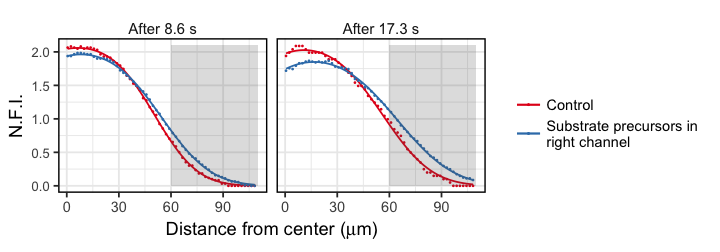

In [49]:
options(repr.plot.width = 6, repr.plot.height = 2.1)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(result,Experiment.Type != "b",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_line(aes(y = control.pred,color = cols[2])) +
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_point(size = 0.1) +
    geom_line(aes(y = pred)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate precursors in\nright channel")) +
    facet_grid(. ~ Experiment,
               labeller = labeller(Experiment =c(t1 = 'After 8.6 s',t2 = 'After 17.3 s'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=8),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)
#          legend.position='bottom') +
          )+
#     annotate("rect", xmin = xmin, xmax = -60, ymin = 0.000025, ymax = +1.00091, alpha = .2)
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +2.1, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

### Redoing part 2 of the graph

In [50]:
cascade.DF <- read.csv("../data/cascade_time.csv")

In [51]:
cascade.DF$Experiment <- factor(cascade.DF$Experiment,levels = c ('Glucose.Channel','Glucose.Mannose.Channel','Ald'))
cascade.DF$Time <- as.factor(cascade.DF$Time)

In [52]:
options(repr.plot.width = 5, repr.plot.height = 2)
barchart <- ggplot(data = cascade.DF , 
                     aes(x=Time, y= Enzyne,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())+
    geom_errorbar(aes(ymin = Enzyne-StDev,ymax = Enzyne+StDev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#377eb8","#a6cee3"),labels = 
                  c("HK in Glucose Channel","HK in Glu-Mannose Channel","Aldolase in Glucose Channel"))

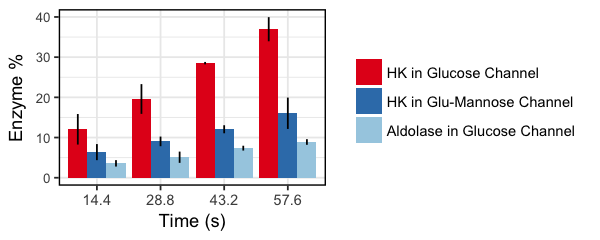

In [53]:
print(barchart)

### Redoing graph 6

In [54]:
fig6.DF <- read.csv("../data/fig6v2.csv")

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../data/fig6v2.csv'”

In [55]:
fig6.DF

time,conc,experiment,stdev
43.2,5.25,hk,0.7
57.6,9.86,hk,1.4
43.2,1.99,ald,0.3
57.6,3.37,ald,1.0


In [56]:
fig6.DF$time <- as.factor(fig6.DF$time)
fig6.DF$experiment <- factor(fig6.DF$experiment,levels=c("hk","ald"))

In [71]:
options(repr.plot.width = 4.6, repr.plot.height = 2)
barchart2 <- ggplot(data = fig6.DF , 
                     aes(x=time, y= conc,fill = experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line(),
         legend.key = element_rect(size = 5),
         legend.key.size = unit(1.6, "lines"))+
    geom_errorbar(aes(ymin = conc-stdev,ymax = conc+stdev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#a6cee3"),labels = 
                  c("HK in Glucose Channel \nwith Ficoll PM 70 (20% w/v)","Aldolase in Glucose Channel \nwith Ficoll PM 70 (20% w/v)"))

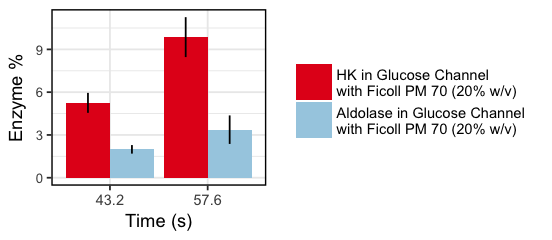

In [72]:
print(barchart2)

In [32]:
ggsave("./img/fig6v2.png",width = 4.6, height = 2)

ERROR: Error in grDevices::dev.off(): QuartzBitmap_Output - unable to open file './img/fig6v2.png'


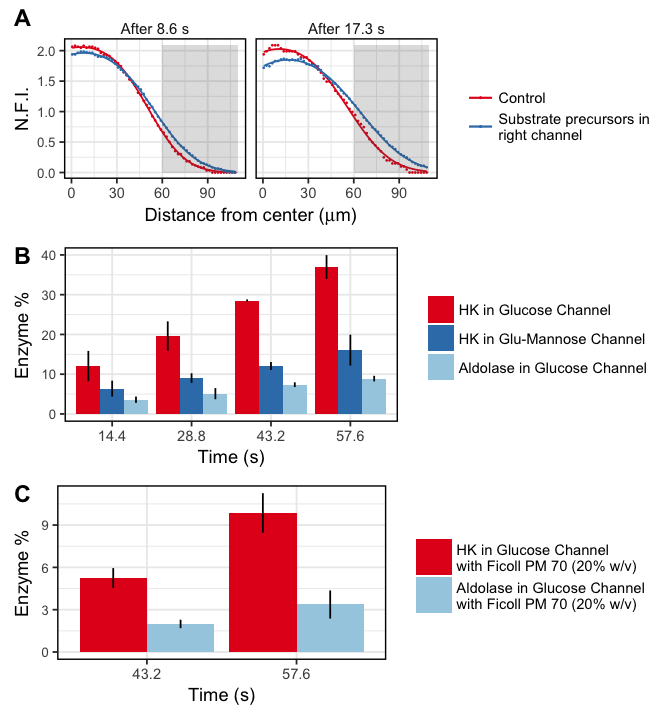

In [73]:
options(repr.plot.width = 5.6, repr.plot.height = 6)

plot_grid(raw,barchart,barchart2, labels = c("A","B","C"),ncol = 1)

In [74]:
ggsave("../img/fig6v7.png",width = 5.6, height = 6)